# Import

In [1]:
# IMPORT PACKAGES
import torch
import lightning as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger,WandbLogger 
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# IMPORT from mlcolvar 
from mlcolvar.data import DictModule
from mlcolvar.core.transform import Normalization,Statistics
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.utils.plot import muller_brown_potential_three_states, plot_isolines_2D, plot_metrics
from mlcolvar.utils.trainer import MetricsCallback

# IMPORT utils functions fo input generation
from utils.generate_input import gen_input_md,gen_input_md_potential,gen_plumed 

# IMPORT and setup wandb
import wandb 
import os
os.environ['WANDB_SILENT']="true"
os.environ['WANDB_NOTEBOOK_NAME'] = 'paper_unsupervised.ipynb'
os.environ['WANDB_MODE']="online"

# suppress warnings
import warnings
warnings.filterwarnings("once")

# Set seed for reproducibility
torch.manual_seed(42)

# plumed setup
PLUMED_SOURCE = '/home/etrizio@iit.local/Bin/dev/plumed2-dev/sourceme.sh'
PLUMED_EXE = f'source {PLUMED_SOURCE} && plumed'
PLUMED_VES_MD = f"{PLUMED_EXE} ves_md_linearexpansion < input_md.dat"

#test plumed
subprocess.run(f"{PLUMED_EXE}", shell=True, executable='/bin/bash')

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Invalid MIT-MAGIC-COOKIE-1 key

Nothing to do. Use 'plumed help' for help


CompletedProcess(args='source /home/etrizio@iit.local/Bin/dev/plumed2-dev/sourceme.sh && plumed', returncode=0)

# Muller Brown modified potential

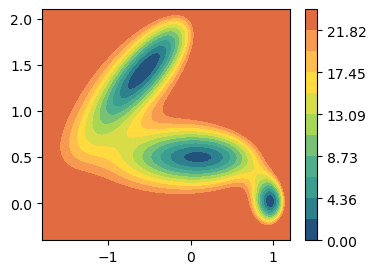

In [2]:
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax)
MULLER_BROWN_FORMULA='0.15*(146.7-280*exp(-15*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-170*exp(-1*(x-0.2)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

# Autoencoder CV on unlabeled data
We start from information limited to state A (top left) and try to explore the rest of the world iteratively building autoencoder CVs on a progressively increasing dataset.

In [3]:
from mlcolvar.cvs import AutoEncoderCV

## Functions
As we will procede iteratively we define auxiliary funcitons for the different stages of the procedure to be used in a loop

### Load Data

In [4]:
def load_data(filenames):
    # load dataset
    dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, create_labels=False, verbose=False)

    # create datamodule for trainer
    datamodule = DictModule(dataset,lengths=[0.8,0.2])
    return datamodule, dataset, df

def plot_training_points(df, iter_folder, iter):
    fig,ax = plt.subplots(figsize=(4,3))
    plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
    df.plot.scatter('p.x','p.y',s=1,cmap='fessa',ax=ax)
    ax.set_title(f'Training set - {iter}')
    plt.savefig(f'{iter_folder}/training_set.png')
    plt.show()

### Define autoencoder model

In [5]:
def ae_model(encoder_layers):
    nn_args = {'activation': 'shifted_softplus'}
    options= {'encoder': nn_args, 'decoder': nn_args }
    model = AutoEncoderCV (encoder_layers, options=options )
    return model

### Define Trainer & Fit

In [6]:
def ae_trainer(model, datamodule, project, iter):
    # define callbacks
    metrics = MetricsCallback()
    early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=10)
    wandb.finish()
    logger = WandbLogger(project=project, name=f'iter_{iter}')
    # define trainer
    trainer = pl.Trainer(accelerator='cuda',callbacks=[metrics, early_stopping], max_epochs=10000,
                            logger=logger, enable_checkpointing=False, enable_model_summary=False)
    # fit
    trainer.fit( model, datamodule )
    return logger, metrics

Normalize output after training

In [7]:
def ae_normalization(model, dataset, n_components):
    X = dataset[:]['data']
    with torch.no_grad():
        model.postprocessing = None # reset  
        s = model(torch.Tensor(X))

    norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
    model.postprocessing = norm
    return model

### Analysis of the CV

In [8]:
def ae_cv_isolines(model, n_components, logger, iter_folder, iter):
    fig,axs = plt.subplots( 1, n_components, figsize=(4*n_components,3) )
    if n_components == 1:
        axs = [axs]
    for i in range(n_components):
        ax = axs[i]
        plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
        plot_isolines_2D(model, component=i, levels=25, ax=ax)
        plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)
    ax.set_title(f'CV isolines - {iter}')
    plt.savefig(f'{iter_folder}/cv_isolines.png')
    plt.show()
    logger.log_image(key='cv',images=[f'{iter_folder}/cv_isolines.png'])

### Run plumed simulation

In [9]:
def ae_run_plumed(iter, iter_folder, initial_position, nsteps, ):
    # create folder
    SIMULATION_FOLDER = f'{iter_folder}/data'
    subprocess.run(f"mkdir {SIMULATION_FOLDER}", shell=True)

    # generate inputs
    gen_plumed(model_name=f'model_autoencoder_{iter}.pt', 
            file_path=SIMULATION_FOLDER, 
            potential_formula=MULLER_BROWN_FORMULA, 
            opes_mode='OPES_METAD')
    gen_input_md(inital_position=initial_position, file_path=SIMULATION_FOLDER, nsteps=nsteps)
    gen_input_md_potential(file_path=SIMULATION_FOLDER)

    subprocess.run(f'{PLUMED_EXE} ves_md_linearexpansion < input_md.dat', cwd=SIMULATION_FOLDER, shell=True, executable='/bin/bash')
    last_conf = load_dataframe(f'{SIMULATION_FOLDER}/COLVAR').iloc[-1][['p.x', 'p.y']].values
    return last_conf, SIMULATION_FOLDER

### Load simulations data

### Visualize sampling

In [10]:
def ae_visualize_sampling(simulation_folder, logger, iter):
    data = load_dataframe(f'{simulation_folder}/COLVAR')
    first_conf = data.iloc[0][['p.x', 'p.y']].values
    last_conf = data.iloc[-1][['p.x', 'p.y']].values
    fig, ax = plt.subplots(figsize=(4,3))
    data.plot.hexbin('p.x', 'p.y', C='opes.bias',cmap='fessa', ax=ax)
    ax.scatter(first_conf[0], first_conf[1], s=20, c='cyan')
    ax.scatter(last_conf[0], last_conf[1], s=20, c='magenta')
    ax.set_title(f'Sampling - {iter}')
    plt.savefig(f'{simulation_folder}/sampling.png')
    plt.show()
    logger.log_image(key='sampling',images=[f'{simulation_folder}/sampling.png'])

# Iterate

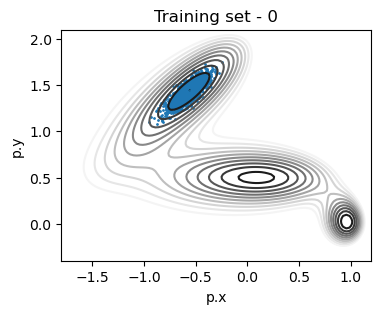

<frozen importlib._bootstrap>:914: ImportWarning: ImportHookFinder.find_spec() not found; falling back to find_module()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 62.85it/s, v_num=wn1l] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


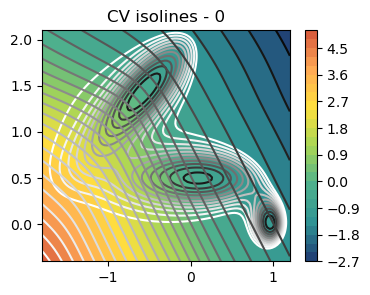

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


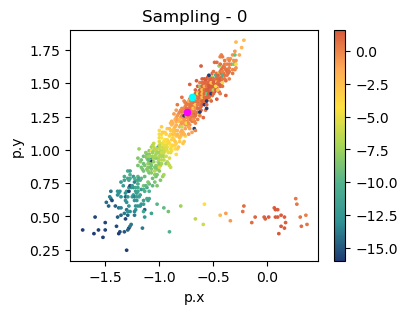

<frozen importlib._bootstrap>:914: ImportWarning: ImportHookFinder.find_spec() not found; falling back to find_module()


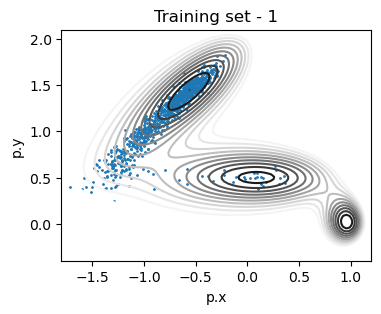

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 61.59it/s, v_num=na9z] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


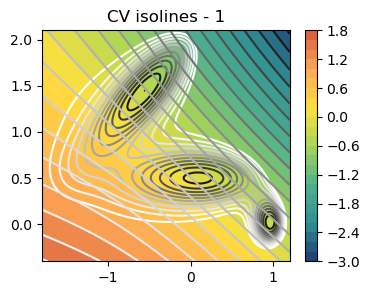

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


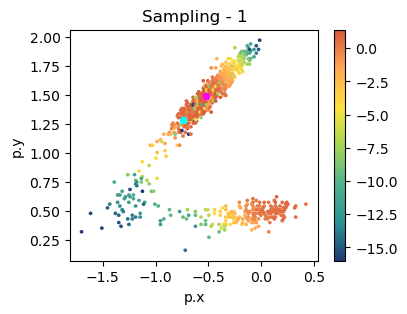

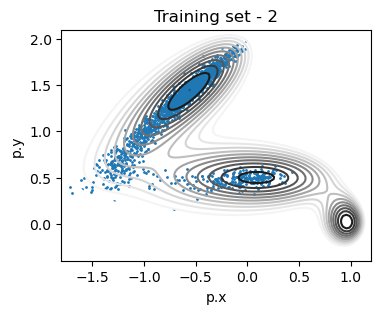

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1139: 100%|██████████| 1/1 [00:00<00:00, 70.09it/s, v_num=4r82] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


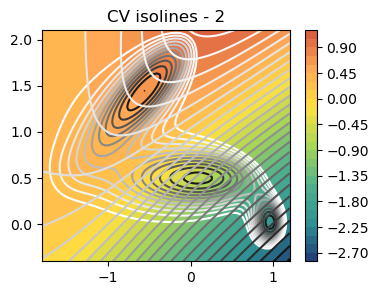

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


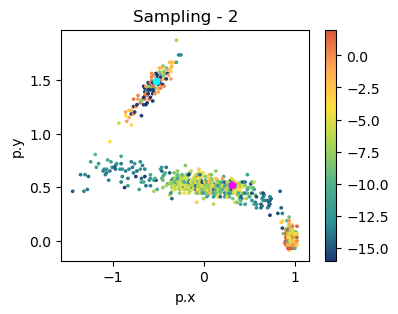

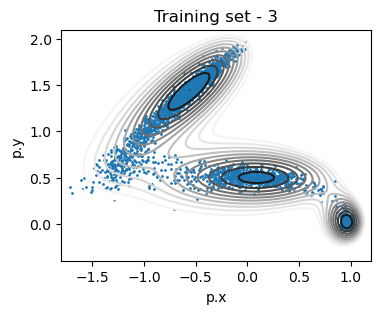

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 73.36it/s, v_num=9pex] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


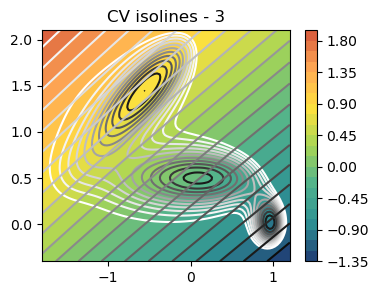

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


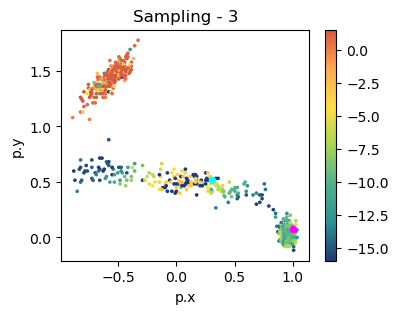

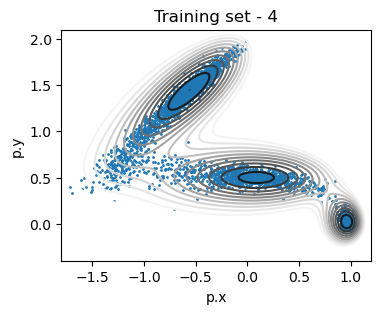

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1769: 100%|██████████| 1/1 [00:00<00:00, 66.88it/s, v_num=ctos] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


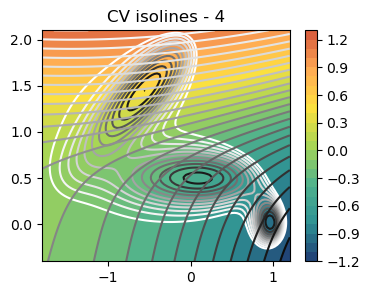

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


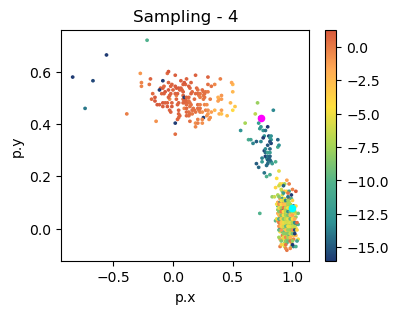

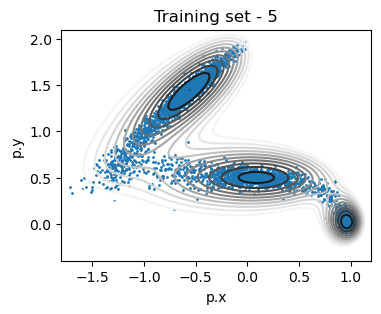

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2044: 100%|██████████| 1/1 [00:00<00:00, 66.62it/s, v_num=j81d] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


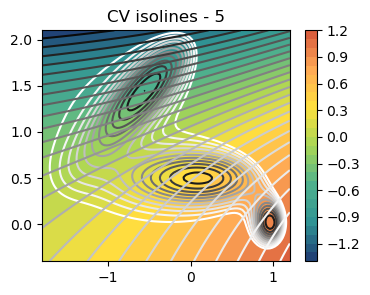

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


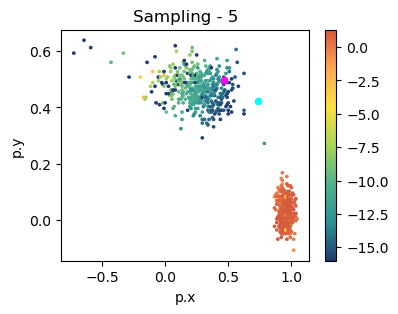

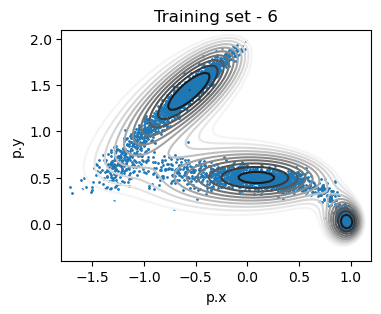

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 69.37it/s, v_num=0lr4] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


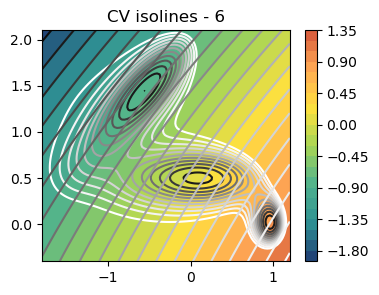

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


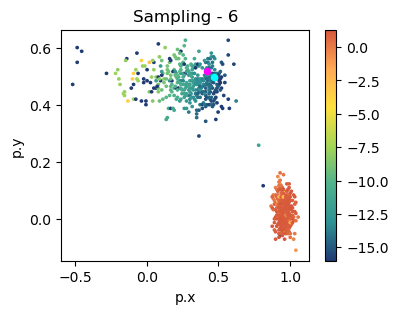

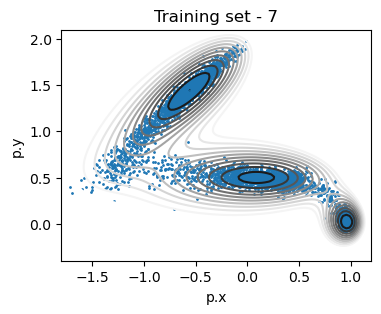

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 67.84it/s, v_num=ifgo] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


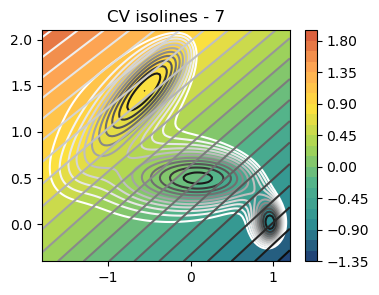

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


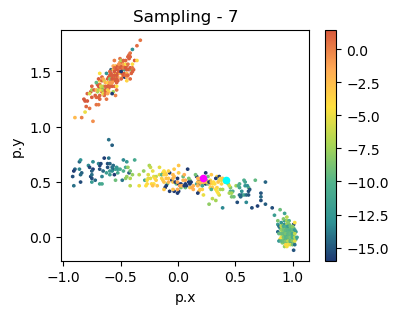

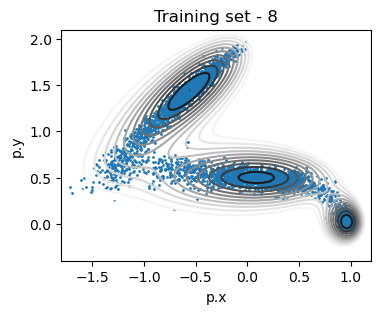

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 68.23it/s, v_num=7qx5] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


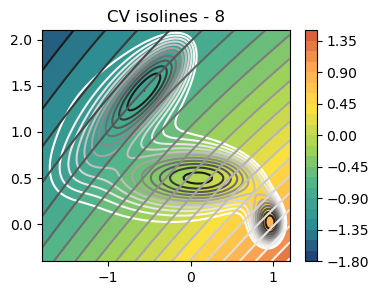

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


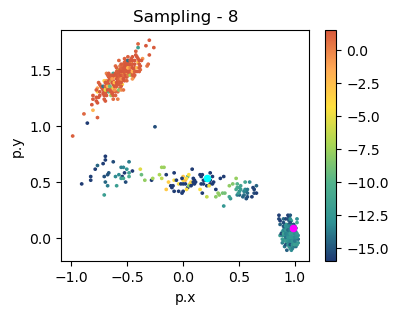

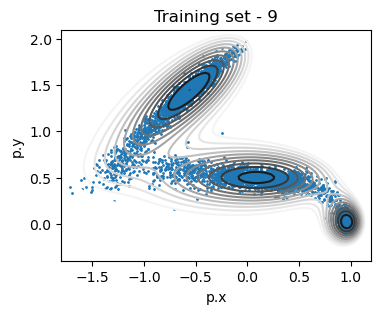

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 68.59it/s, v_num=qaox] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


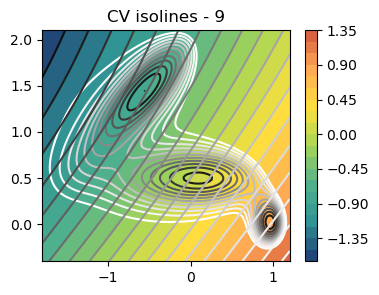

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


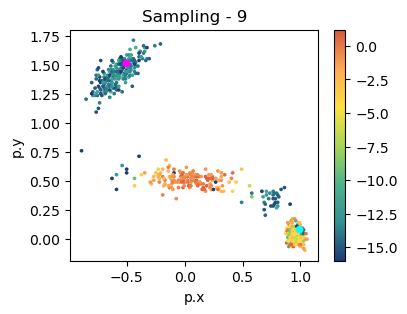

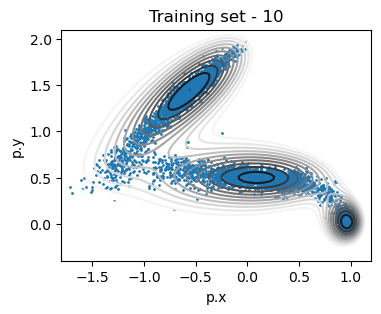

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 59.23it/s, v_num=1sfg] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


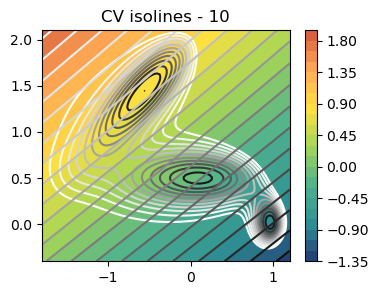

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


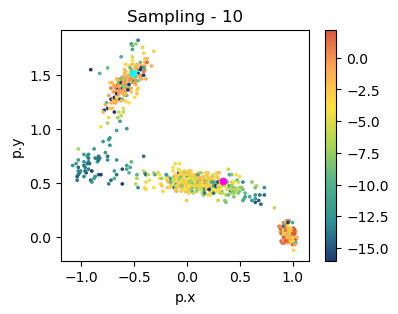

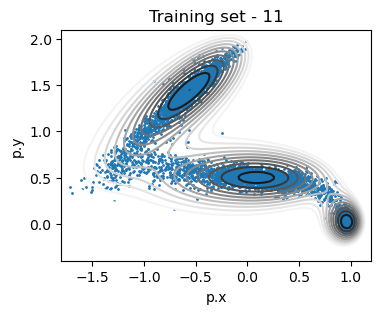

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 65.32it/s, v_num=lr93] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


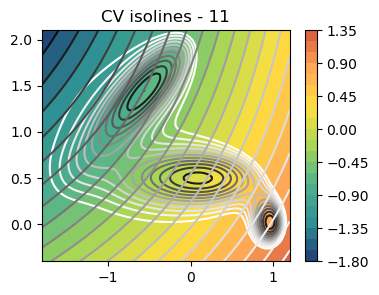

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


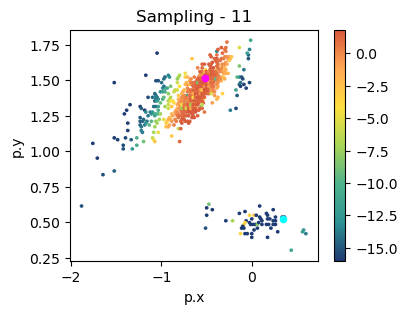

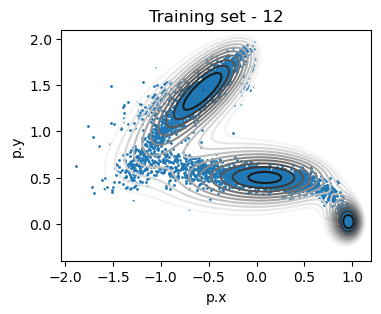

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s, v_num=r78j] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


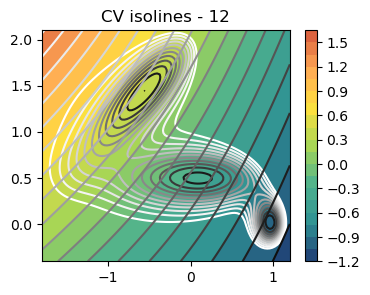

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


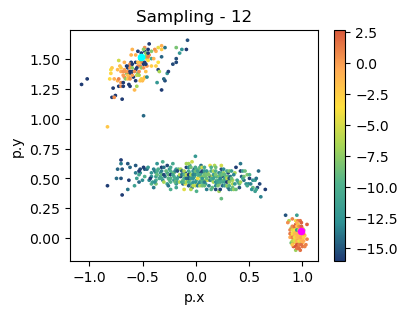

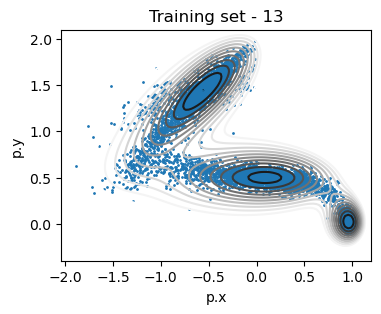

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 65.39it/s, v_num=9qgy] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


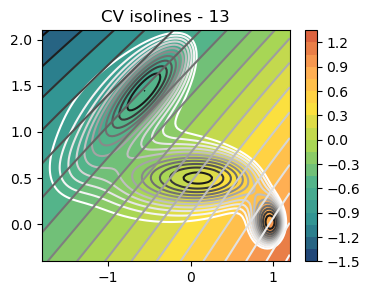

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


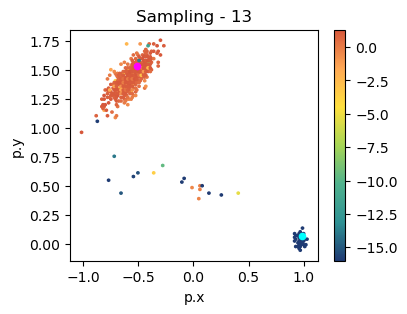

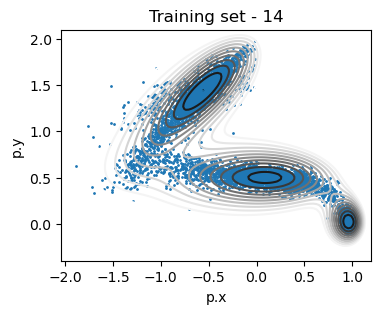

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 61.22it/s, v_num=3v0p] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


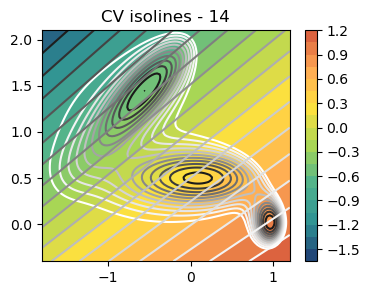

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


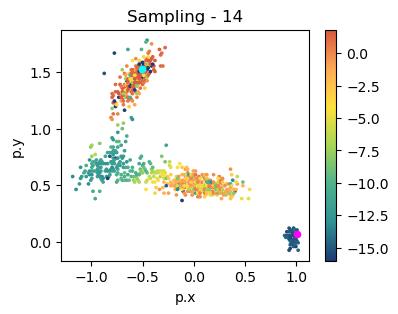

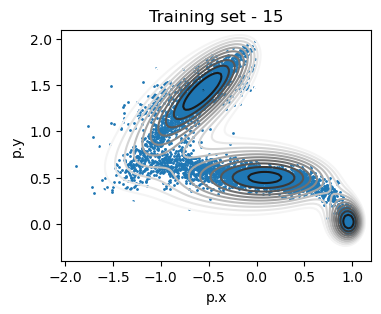

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2004: 100%|██████████| 1/1 [00:00<00:00, 63.35it/s, v_num=dih5] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


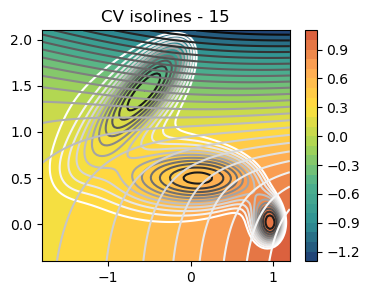

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


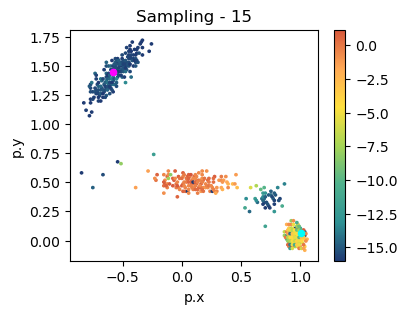

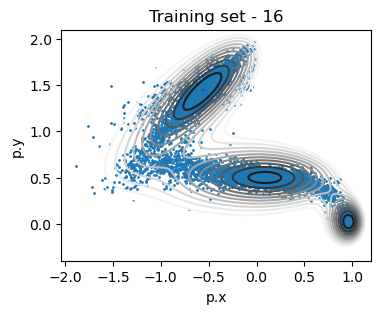

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 56.78it/s, v_num=gma8] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


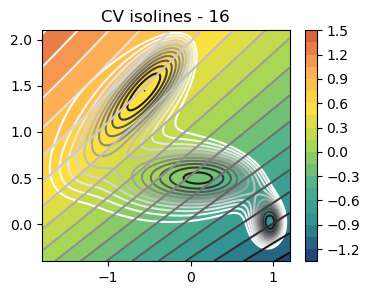

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


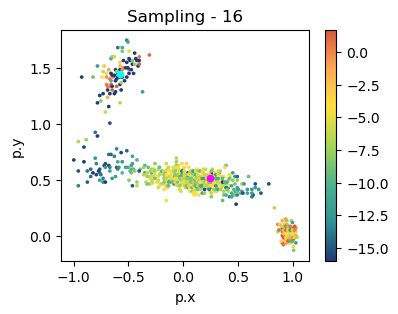

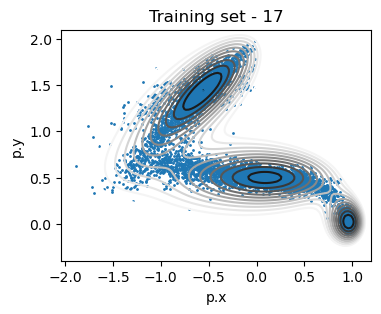

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 70.24it/s, v_num=sodm] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


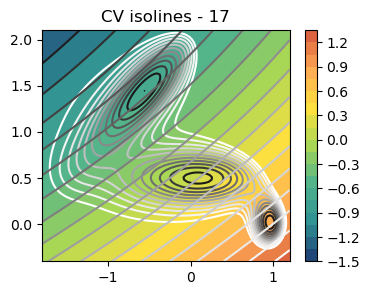

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


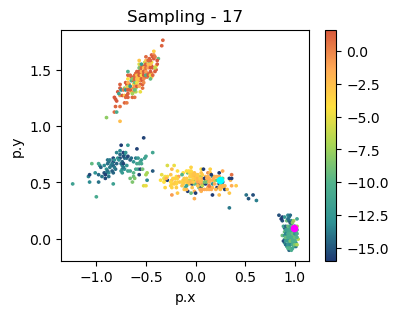

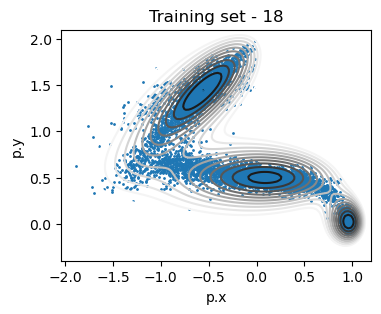

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1835: 100%|██████████| 1/1 [00:00<00:00, 70.05it/s, v_num=5j9b] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


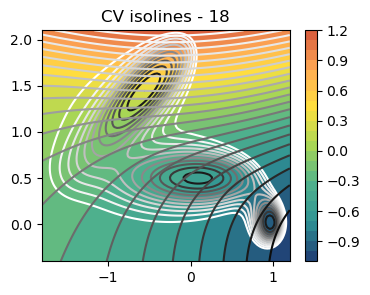

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


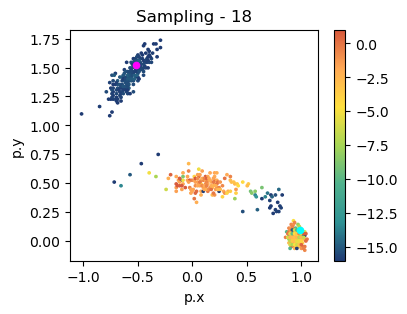

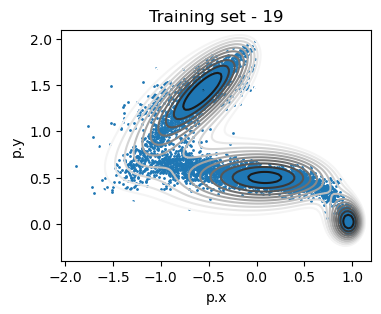

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 70.49it/s, v_num=ifn3] 


/home/etrizio@iit.local/Bin/dev/mlcvs/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


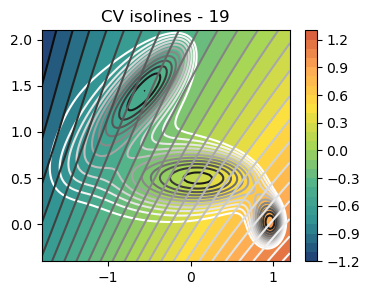

Invalid MIT-MAGIC-COOKIE-1 key

Replicas                              1
Cores per replica                     1
Number of steps                       100000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -42
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


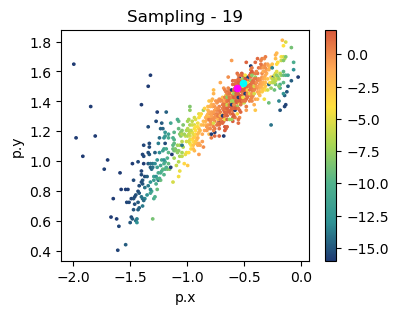

In [11]:
# set operation folder
RESULTS_FOLDER = '../data/unsupervised'
# subprocess.run(f"rm -r {RESULTS_FOLDER}", shell=True)
# subprocess.run(f"mkdir {RESULTS_FOLDER}", shell=True)

# procedure parameters
use_all_data = True # keep all the previous data
n_components = 1 # size of the latent space
encoder_layers = [2,20,20,n_components]

for iter in range(20):
    # create folder for current iteration
    ITER_FOLDER = RESULTS_FOLDER+f'/iter_{iter}'
    subprocess.run(f"mkdir {ITER_FOLDER}", shell=True)

    if iter == 0:
        filenames = ["../../data/muller-brown-3states/unbiased/state-0/COLVAR"]
    else:
        if use_all_data: 
            filenames = [f"{RESULTS_FOLDER}/iter_{i}/data/COLVAR" for i in range(iter) ]
        else:
            filenames = [f"{RESULTS_FOLDER}/iter_{iter-1}/data/COLVAR"]

    # 1 - Load and visualize unlabeled data
    datamodule, dataset, df = load_data(filenames)
    plot_training_points(df, ITER_FOLDER, iter)

    # 2 - Initialize model
    model = ae_model(encoder_layers)

    # 3 - Initialize trainer and train
    logger, metrics = ae_trainer(model, datamodule, project='paper_autoencoder', iter=iter)
    logger.log_image(key='training',images=[f'{ITER_FOLDER}/training_set.png'])
    
    # 4 - Apply normalization on the output
    model = ae_normalization(model, dataset, n_components)
    
    # 5 - Export and visualize the model
    traced_model = model.to_torchscript(file_path=f'{ITER_FOLDER}/model_autoencoder_{iter}.pt', method='trace')
    ae_cv_isolines(model, n_components, logger, ITER_FOLDER, iter)
    
    # 6 - RUM PLUMED simulation
    if iter == 0:
        initial_positions = '-0.7,1.4'
    else:
        initial_positions = f"{last_conf[0]},{last_conf[1]}"
    last_conf, SIMULATION_FOLDER = ae_run_plumed(iter, ITER_FOLDER, initial_position=initial_positions, nsteps=100000)
    ae_visualize_sampling(SIMULATION_FOLDER, logger, iter)
    
    # close wandb logging
    wandb.finish()


In [12]:
model

AutoEncoderCV(
  (loss_fn): MSELoss()
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (postprocessing): Normalization(in_features=1, out_features=1, mode=min_max)
)

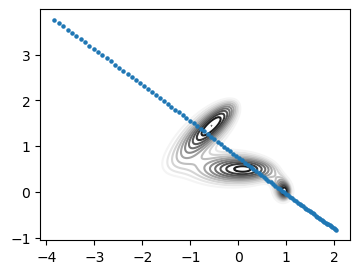

In [13]:
samples = torch.linspace(-4,4, 100).unsqueeze(-1)
samples.shape
miao = model.decoder(samples)
            # x = self.norm_in.inverse(x)
miao = model.norm_in.inverse(miao)
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax, mode='contour', zorder=0)
plt.scatter(miao.detach().numpy()[:,0], miao.detach().numpy()[:, 1], s=5)
